In [303]:
from vcdvcd import VCDVCD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [304]:
# Load the file
vcd1 = VCDVCD("../test_run_dir/Display_should_generate_appropriate_pulses/DisplayController.vcd")
print(vcd1.signals)

clock = "TOP.DisplayController.clock"
mda_vsync = "TOP.DisplayController.io_mda_vsync"
mda_hsync = "TOP.DisplayController.io_mda_hsync"
mda_intensity = "TOP.DisplayController.io_mda_intens"
mda_data = "TOP.DisplayController.io_mda_pixel"

"""
clock = "sim.clock"
mda_vsync = "sim.MDA_VSYNC"
mda_hsync = "sim.MDA_HSYNC"
mda_intensity = "sim.MDA_INTENSITY"
mda_data = "sim.MDA_DATA"
"""

['TOP.clock', 'TOP.io_mda_hsync', 'TOP.io_mda_intens', 'TOP.io_mda_pixel', 'TOP.io_mda_vsync', 'TOP.io_tp_mode[2:0]', 'TOP.reset', 'TOP.DisplayController.clock', 'TOP.DisplayController.font_rom_io_char_char_code[7:0]', 'TOP.DisplayController.font_rom_io_pixel', 'TOP.DisplayController.font_rom_io_x_idx[3:0]', 'TOP.DisplayController.font_rom_io_y_idx[3:0]', 'TOP.DisplayController.hblank', 'TOP.DisplayController.io_mda_REG_hsync', 'TOP.DisplayController.io_mda_REG_pixel', 'TOP.DisplayController.io_mda_REG_vsync', 'TOP.DisplayController.io_mda_hsync', 'TOP.DisplayController.io_mda_intens', 'TOP.DisplayController.io_mda_pixel', 'TOP.DisplayController.io_mda_vsync', 'TOP.DisplayController.io_tp_mode[2:0]', 'TOP.DisplayController.pix_valid', 'TOP.DisplayController.pixel', 'TOP.DisplayController.reset', 'TOP.DisplayController.vblank', 'TOP.DisplayController.wrap_wrap', 'TOP.DisplayController.wrap_wrap_1', 'TOP.DisplayController.wrap_wrap_2', 'TOP.DisplayController.wrap_wrap_3', 'TOP.DisplayCon

'\nclock = "sim.clock"\nmda_vsync = "sim.MDA_VSYNC"\nmda_hsync = "sim.MDA_HSYNC"\nmda_intensity = "sim.MDA_INTENSITY"\nmda_data = "sim.MDA_DATA"\n'

In [305]:
# sample on falling edges to ensure determinism
edges = [x[0] for x in vcd1[clock].tv if x[1] == '0']
print(len(edges))

1200001


In [306]:
# sample the pixels
pixels = [(
    int(vcd1[mda_vsync][x]),
    int(vcd1[mda_hsync][x]),
    int(vcd1[mda_intensity][x]),
    int(vcd1[mda_data][x])
) for x in edges]

In [307]:
# trim to start of first frame
first_vsync = [i for i, x in enumerate(pixels) if x[0] == 0]
first_vsync = first_vsync[0]
pixels = pixels[first_vsync:]

first_pixel = [i for i, x in enumerate(pixels) if x[0] == 1]
first_pixel = first_pixel[0]
pixels = pixels[first_pixel:]

frames = []

while len(pixels):
    first_vsync = [i for i, x in enumerate(pixels) if x[0] == 0]
    if len(first_vsync) == 0: break
    first_vsync = first_vsync[0]
    tmp = pixels[:first_vsync]
    pixels = pixels[first_vsync:]

    first_pixel = [i for i, x in enumerate(pixels) if x[0] == 1]
    if len(first_pixel) == 0: break
    first_pixel = first_pixel[0]
    tmp += pixels[:first_pixel]
    pixels = pixels[first_pixel:]
    
    frames.append(tmp)

In [308]:
print(len(frames))
print([len(x) for x in frames])

3
[323545, 326196, 326196]


In [309]:
frame = frames[1]

In [310]:
img = np.zeros((400, 1000, 3), dtype=np.uint8)

x = 0
y = 0

max_x = 0
max_y = 0

last_hs = 0

for vs, hs, intens, data in frame:
    
    if last_hs and not hs:
        x = 0
        y += 1
    
    # green channel = pixel
    if data and intens: img[y,x,1] = 255
    elif data: img[y,x,1] = 190
    else: img[y,x,1] = 0

    # red channel = hsync
    img[y,x,0] = 160 * hs
    
    # blue channel = vsync
    img[y,x,2] = 255 * (not vs)
    
    x += 1
    
    max_x = max(x, max_x)
    max_y = max(y+1, max_y)
    
    last_hs = hs
    
img = img[:max_y, :max_x]

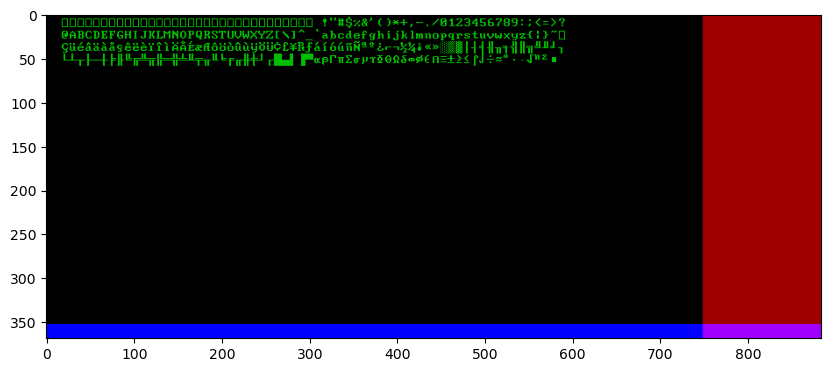

In [311]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.imsave("image.png", img)